<a href="https://colab.research.google.com/github/Arnoldsynchron/2016-ml-contest/blob/master/Deeplearning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deeplearning in Prediction of Geological Facies(Convolution Neural Nets)**

Prediction of geological surface using available data found in the github [seg](www.github.c0m/seg) repository


In [53]:
from google.colab import drive
drive.mount('/content/gdrive')
# ls '/content/gdrive/My Drive/Data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [195]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
from pandas import set_option

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

from collections import Counter
import operator

from keras.models import Model, Sequential
from keras.layers import Convolution1D, Convolution2D, Dense, Input, Dropout, Flatten, MaxPooling2D, Activation, normalization
from keras.optimizers import Nadam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import History

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
np.random.seed(123)

In [196]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
  
def accuracy_adj(conf, adjacent_facies):
  total_correct = 0
  nb_classes = conf.shape[0]
  for i in np.arange(0, nb_classes):
    total_correct +=conf[i][i]
    for j in adjacent_facies[i]:
      total_correct += conf[i][j]
  return total_correct/sum(sum(conf))

file = pd.read_csv('/content/gdrive/My Drive/Data/train_test_data.csv')

In [197]:
print(file.isna().mean().sort_values(ascending=False))
file.head()

PE           0.184174
RELPOS       0.000000
NM_M         0.000000
PHIND        0.000000
DeltaPHI     0.000000
               ...   
GR           0.000000
Depth        0.000000
Well Name    0.000000
Formation    0.000000
Facies       0.000000
Length: 11, dtype: float64


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


# Prediction of PE values


In [199]:
file[file['PE'].notnull()]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4974,0,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
4975,0,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
4976,0,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
4977,0,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [200]:
def prepare_feature_vectors(data, features, window_width):

    raw_feature_vectors = data[features]
    well_labels = data['Well Name']
    num_features = np.shape(raw_feature_vectors)[1]

    output = np.zeros((1, window_width, num_features))
    for x in well_labels.unique():
        well = raw_feature_vectors[well_labels == x].values
        well = np.concatenate((np.repeat(well[0:1], np.floor((window_width-1)/2.0), axis=0), well,
                              np.repeat(well[-1:None], np.floor(window_width/2.0), axis=0)), axis=0)

        tmp = np.zeros((np.size(well, axis=0) - window_width + 1, window_width, num_features))
        for i in np.arange(np.size(well, axis=0) - window_width + 1):
            tmp[i] = np.reshape(well[i: i + window_width], (window_width, num_features))

        output = np.append(output, tmp, axis=0)

    return output[1:]

Remove the P.E values of Stuart and Crawford Wells


In [206]:
def file_copy(file):
  data = file.copy()
  data = data[data['Well Name'] != 'STUART']
  data = data[data['Well Name'] != 'CRAWFORD']
  return data

Split Data into Training and Testing

In [209]:
data['PE'].isnull().sum()

917

In [208]:
window_width = 15 #Window around the central value
data = file_copy(file)
feature_list = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']
X_train = prepare_feature_vectors(data[data['PE'].notnull()], feature_list, window_width)
num_train_samples = np.asarray(np.shape(X_train))[0]

X_test = prepare_feature_vectors(data[data['PE'].isnull()], feature_list, window_width)
num_test_samples = np.asarray(np.shape(X_test))[0]

print('Training Samples=', num_train_samples, '   Test Samples=', num_test_samples)

Training Samples= 3232    Test Samples= 917


Neural Network to Predict the Missing PE Values

In [177]:
# define neural network to perform regression on PE
num_filters = 12
dropout_prob = 0.6666

cnn = Sequential()
cnn.add(Convolution1D(num_filters, 1, border_mode='valid', input_shape=(window_width, len(feature_list))))
cnn.add(normalization.BatchNormalization())
cnn.add(Activation('tanh'))
cnn.add(Convolution1D(num_filters, 3, border_mode='valid'))
cnn.add(normalization.BatchNormalization())
cnn.add(Activation('tanh'))
cnn.add(Dropout(dropout_prob / 2))

cnn.add(Flatten())
cnn.add(Dense(4*num_filters))
cnn.add(normalization.BatchNormalization())
cnn.add(Activation('tanh'))
cnn.add(Dropout(dropout_prob))

cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])
cnn.summary()

# save initial weights, which are random
initial_weights = cnn.get_weights()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 15, 12)            84        
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 12)            48        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 12)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 13, 12)            444       
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 12)            48        
_________________________________________________________________
activation_11 (Activation)   (None, 13, 12)            0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 13, 12)          

In [178]:
Y_train = data[data['PE'].notnull()]['PE'].values

In [180]:
# define training parameters and prepare arrays to store training metrics
epochs_per_fold = 1000
num_fold = 5
roll_stride = np.ceil(num_train_samples/num_fold).astype(int)

cnn_hist = History()
hist = np.zeros((4, num_fold, epochs_per_fold))
f1scores = np.zeros(num_fold)
Y_test = np.zeros((num_test_samples, num_fold))


# shuffle input data
rand_perm = np.random.permutation(num_train_samples)
X_train = X_train[rand_perm]
Y_train = Y_train[rand_perm]

In [181]:
# use 5-fold cross validation and train 5 neural networks, ending up with 5 sets of predictions
for i in np.arange(num_fold):
    cnn.set_weights(initial_weights)
    X_train = np.roll(X_train, i*roll_stride, axis=0)
    Y_train = np.roll(Y_train, i*roll_stride, axis=0)

    cnn.fit(X_train, Y_train, batch_size=150, nb_epoch=epochs_per_fold, verbose=0,
                validation_split=1.0/num_fold, callbacks=[cnn_hist])

    # make predictions, i.e. impute PE
    Y_test[:, i] = cnn.predict(X_test)[:, 0]

    hist[:, i, :] = [cnn_hist.history['acc'], cnn_hist.history['val_acc'],
                     cnn_hist.history['loss'], cnn_hist.history['val_loss']]
    print("Accuracy  =", np.mean(hist[1, i, -100:]))

Accuracy  = 0.05089644446969032
Accuracy  = 0.031715610884130004
Accuracy  = 0.04182380210608244
Accuracy  = 0.0322720249556005
Accuracy  = 0.05210200857371092


In [182]:
import matplotlib.pyplot as plt

Mean Validation Accuracy  = 0.04176197819784284


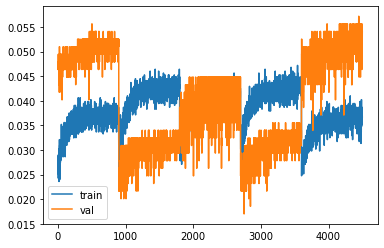

In [183]:
# plot callbacks to evaluate quality of training
drop_values = 100
drop_hist = np.reshape(hist[:, :, drop_values:], (4, num_fold * (epochs_per_fold - drop_values)))
print("Mean Validation Accuracy  =", np.mean(hist[1, :, -drop_values:]))

plt.plot(drop_hist[0]); plt.plot(drop_hist[1])
plt.legend(['train', 'val'], loc='lower left')

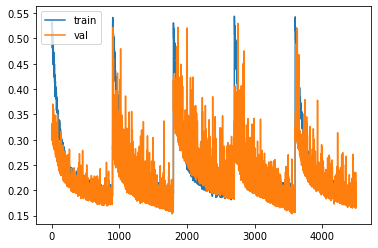

In [184]:
plt.plot(drop_hist[2]); plt.plot(drop_hist[3])
plt.legend(['train', 'val'], loc='upper left')

In [210]:
# Update dataframe with imputed values by averaging results of 5 neural networks 
data['PE'][np.array(data['PE'].isnull())] = np.mean(Y_test, axis=1)

# Write intermediate data to file
data.to_csv('/content/gdrive/My Drive/Data/train_test_data_PEfilled.csv', index=False)

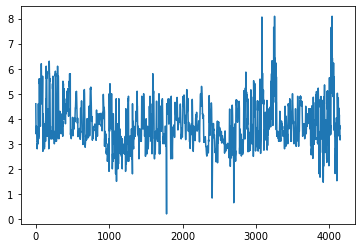

In [211]:
# Plot PE of all wells (original plus imputed) 
plt.plot(data['PE'])

In [212]:
data['PE'].isnull().sum() #No missing PE Values 

0

# Facies Prediction


In [228]:
file_2 = file.copy()
names = file['Well Name'].unique()
for name in names:
  if name not in ['STUART','CRAWFORD']:
    file_2 = file_2[file_2['Well Name'] != name]
file_2.shape

(830, 11)

In [230]:
file_ii = pd.read_csv('/content/gdrive/My Drive/Data/train_test_data_PEfilled.csv')
training_data = pd.concat([file_ii, file_2], axis = 0)
print(training_data.shape)
training_data.head()

(4979, 11)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


## Data Wrangling



In [231]:
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
  #mapping facies labels to the dataframe
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'FaciesLabels', 'Facies','Well Name'], axis=1) #, 'RELPOS', 'NM_M', 'Depth', 'ILD_log10',  'DeltaPHI',   'PHIND'], axis=1)

well_labels = training_data[['Well Name', 'Facies']].values
well_name = training_data['Well Name'].values
depth = training_data['Depth'].values


In [232]:
training_data[:3]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS


In [233]:

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

data_out = np.hstack([well_labels, scaled_features])

# Data Transform


In [234]:
data = data_out
well_data = {}
well_names = list(set(data[:, 0])) #set of well names
for name in well_names:
    well_data[name] = [[], []] #creates a dictionary containing list of list for the well names
    
for row in data:
    well_data[row[0]][1].append(row[1]) #Append facies to the second list[]
    well_data[row[0]][0].append(list(row[2::])) #Append features to the first list[]

#For data padding
positive_lag = 10
negative_lag = 11

chunks_cnn = []
chunks_cnn_test = []
chunk_length = positive_lag+negative_lag+1 #were gonna predict middle facies
chunks_facies_cnn = []

for name in well_names:
    if name not in ['STUART', 'CRAWFORD']:  #Training set augumentation
        test_well_data = well_data[name]    #Returns a list of list
        log_values = np.array(test_well_data[0]) #values
        log_values_padded = np.lib.pad(log_values, (negative_lag,positive_lag), 'edge')[:, negative_lag:-positive_lag] #Pad values(11,10) and 
                                                                                        #returns index from 11:-10
        facies_values =  np.array(test_well_data[1])
        for i in range(log_values.shape[0]):
            chunk = log_values_padded[i:i+chunk_length, :]
            chunk_trans = chunk.T
            chunks_cnn.append(chunk_trans)
            chunks_facies_cnn.append(facies_values[i])
    else:
        test_well_data = well_data[name]
        log_values = np.array(test_well_data[0])
        log_values_padded = np.lib.pad(log_values, (negative_lag,positive_lag), 'edge')[:, negative_lag:-positive_lag]
        facies_values =  np.array(test_well_data[1])
        for i in range(log_values.shape[0]):
            chunk = log_values_padded[i:i+chunk_length, :]
            chunk_trans = chunk.T
            chunks_cnn_test.append(chunk_trans)

chunks_cnn = np.array(chunks_cnn)
chunks_cnn_test = np.array(chunks_cnn_test)

chunks_facies_cnn = np.array(chunks_facies_cnn, dtype=np.int32)-1

unique_facies = len(set(chunks_facies_cnn))
print (unique_facies, set(chunks_facies_cnn))
print (chunks_cnn.shape, chunks_cnn_test.shape)
print (chunks_facies_cnn.shape, chunks_cnn_test.shape)

9 {0, 1, 2, 3, 4, 5, 6, 7, 8}
(4149, 8, 22) (830, 8, 22)
(4149,) (830, 8, 22)


In [235]:
X = chunks_cnn #Save data to X and Y for training
y = chunks_facies_cnn

X = X.reshape((chunks_cnn.shape[0], chunks_cnn.shape[1], chunks_cnn.shape[2], 1))

y = np_utils.to_categorical(y)

In [236]:
N = 128
cnnet = Sequential()
cnnet.add(Convolution2D(N, 1, 5, border_mode="same",activation="relu",input_shape=(chunks_cnn.shape[1], chunks_cnn.shape[2], 1)))
cnnet.add(MaxPooling2D(pool_size=(1, 2)))
cnnet.add(Dropout(0.25))
cnnet.add(Convolution2D(N, 1, 3, border_mode="same",activation="relu",input_shape=(chunks_cnn.shape[1], chunks_cnn.shape[2], 1)))
cnnet.add(MaxPooling2D(pool_size=(1, 2)))
#cnn.add(Dropout(0.5))
cnnet.add(Convolution2D(N, 2, 2, border_mode="same", activation="relu"))
#cnn.add(Convolution2D(N, 3, 1, border_mode="same", activation="relu"))
cnnet.add(MaxPooling2D(pool_size=(2, 2)))
cnnet.add(Dropout(0.8))
cnnet.add(Flatten())
cnnet.add(Dense(128, activation="relu"))
cnnet.add(Dropout(0.5))
cnnet.add(Dense(64, activation="relu"))
cnnet.add(Dropout(0.5))
cnnet.add(Dense(9, activation="softmax"))
cnnet.compile(loss="categorical_crossentropy", optimizer="Adamax", metrics=['acc'])

In [237]:
cnnet.summary()
intial_weights_ii = cnnet.get_weights()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 8, 22, 128)        768       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 11, 128)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 8, 11, 128)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 11, 128)        49280     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 5, 128)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 5, 128)         65664     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 4, 2, 128)       

In [239]:
cnnet_hist = History()
epoch_fold = 200
hist = np.zeros((4, 1, epoch_fold))
start = time.time()
cnnet.fit(X, y, nb_epoch=epoch_fold, validation_split=0.25, batch_size=64, verbose=1, shuffle=True, callbacks=[cnnet_hist])
hist[:,0,:] = [cnnet_hist.history['acc'], cnnet_hist.history['val_acc'], cnnet_hist.history['loss'], cnnet_hist.history['val_loss']]
print(f'Time to train Network {time.time() - start}')

3111/3111 [==============================] - 4s 1ms/step - loss: 0.4786 - acc: 0.8187 - val_loss: 1.7275 - val_acc: 0.4961
Epoch 6/500
3111/3111 [==============================] - 4s 1ms/step - loss: 0.4723 - acc: 0.8267 - val_loss: 1.6959 - val_acc: 0.5058
Epoch 7/500
3111/3111 [==============================] - 4s 1ms/step - loss: 0.4915 - acc: 0.8187 - val_loss: 1.6783 - val_acc: 0.4913
Epoch 8/500
3111/3111 [==============================] - 4s 1ms/step - loss: 0.4533 - acc: 0.8296 - val_loss: 1.7583 - val_acc: 0.4961
Epoch 9/500
3111/3111 [==============================] - 5s 2ms/step - loss: 0.4797 - acc: 0.8235 - val_loss: 1.6595 - val_acc: 0.4817
Epoch 10/500
3111/3111 [==============================] - 8s 3ms/step - loss: 0.4731 - acc: 0.8274 - val_loss: 1.6468 - val_acc: 0.5000
Epoch 11/500
3111/3111 [==============================] - 5s 2ms/step - loss: 0.4784 - acc: 0.8290 - val_loss: 1.6173 - val_acc: 0.5039
Epoch 12/500
3111/3111 [==============================] - 4s 1ms/

AttributeError: ignored

In [ ]:
hist = np.reshape(hist,(4,i*epoch_fold))
plt.plot(hist[0]); plt.plot(hist[1])
plt.legend(['train','val'], loc= 'lower left')

In [ ]:
cnn.get_weights()

In [ ]:
plt.plot(hist[2]); plt.plot(hist[3])
plt.legend(['train', 'val'], loc='upper left')

# Model Predictions


In [241]:
y_predicted = cnnet.predict(X, batch_size=32, verbose=1)

y_preds = []
for row in y_predicted:
    index, value = max(enumerate(row), key=operator.itemgetter(1))
    y_preds.append(index)

print ("" )   
print (confusion_matrix(chunks_facies_cnn, y_preds))
print ('Model F1 score',f1_score(chunks_facies_cnn, y_preds, average='weighted'))
print('Model Accuracy Score',accuracy_score(chunks_facies_cnn,y_preds))

4149/4149 [==============================] - 2s 362us/step

[[259   6   3   0   0   0   0   0   0]
 [  2 878  57   1   2   0   0   0   0]
 [  0  84 692   0   2   0   0   2   0]
 [  0   0   0 217  11  34   0   9   0]
 [  0   0   0   6 191  71   0  28   0]
 [  0   0   1   1   1 524   3  52   0]
 [  0   0   0   3   2   6 121   9   0]
 [  0   0   0   1   2  52   0 631   0]
 [  0   0   0   0   0  15   0  46 124]]
Model F1 score 0.8758738371759398
Model Accuracy Score 0.8765967703060978


In [242]:
conf  = confusion_matrix(chunks_facies_cnn,y_preds)

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
accuracy_adj(conf,adjacent_facies)

0.9744516751024344

In [244]:
X_test = chunks_cnn_test

X_test = X_test.reshape((chunks_cnn_test.shape[0], chunks_cnn_test.shape[1], chunks_cnn_test.shape[2], 1))


y_predicted = cnnet.predict(X_test, batch_size=32, verbose=1)

y_preds = []
for row in y_predicted:
    index, value = max(enumerate(row), key=operator.itemgetter(1))
    y_preds.append(index)
y_preds = np.array(y_preds)+1   
print(y_preds)

830/830 [==============================] - 0s 376us/step
[5 5 8 8 8 8 8 8 8 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6
 6 6 6 5 5 5 5 5 5 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 2 2 1 1 1
 1 1 1 1 1 1 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8 6 6 8 8 6 8 5 5 5 6 5 5 5 5 5 5
 5 5 5 5 8 8 8 8 8 8 8 8 8 6 6 6 6 6 6 6 8 8 8 8 8 6 6 6 6 6 6 6 6 8 8 2 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 8 8 8 8 8 8 8 8 9 9 9 9 9 8 9 9 8 8 7
 7 8 8 8 8 8 8 8 8 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 8 8 8 8 8 8 8 8 8 8
 8 8 6 6 6 6 5 2 2 2 2 2 3 3 2 2 2 2 2 3 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9
 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 1 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 5 8 8 8 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 8 8 8 8 8 8 8 8
 6 5 5 5 6 4 4 4 4 4 4 6 6 6 6 5 6 6 4 6 6 6 8 6 8 9 8 8 8 8 8 8 8 8 8 8 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 8 8 

In [245]:
test_data = pd.read_csv("/content/gdrive/My Drive/Data/validation_data_nofacies_online.csv")
test_data['Facies'] = pd.Series(y_preds)
test_data.to_csv("/content/gdrive/My Drive/Data/validation_data_with_facies_new.csv")

In [58]:
print (test_data.head())

  Formation Well Name   Depth      GR  ...     PE  NM_M  RELPOS  Facies
0     A1 SH    STUART  2808.0  66.276  ...  3.591     1   1.000       2
1     A1 SH    STUART  2808.5  77.252  ...  3.341     1   0.978       2
2     A1 SH    STUART  2809.0  82.899  ...  3.064     1   0.956       2
3     A1 SH    STUART  2809.5  80.671  ...  2.977     1   0.933       2
4     A1 SH    STUART  2810.0  75.971  ...  3.020     1   0.911       2

[5 rows x 11 columns]


In [ ]:
set(y_preds)

{1, 2, 3, 4, 5, 6, 7, 8}

# Prediction on Blind Data

In [246]:
blind_data = pd.read_csv('/content/gdrive/My Drive/Data/blind_stuart_crawford_core_facies.csv')
blind_data.head()

,WellName,Depth.ft,LithCode,LithLabel
0,STUART,2807.5,3,NM Shly Silt
1,STUART,2808.0,3,NM Shly Silt
2,STUART,2808.5,3,NM Shly Silt
3,STUART,2809.0,3,NM Shly Silt
4,STUART,2809.5,3,NM Shly Silt


In [247]:
def merge_test(blind_data, test_data):
  columns = blind_data.WellName.unique()
  merge_col = 0
  for column in columns:
    blind = blind_data[blind_data['WellName'] == column]
    test = test_data[test_data['Well Name']==column]
    if type(merge_col) is int:
      merge_col = pd.merge(blind, test, how = 'inner', left_on = 'Depth.ft', right_on= 'Depth')
    else:
      merge_col_2 = pd.merge(blind, test, how = 'inner', left_on = 'Depth.ft', right_on= 'Depth')
  y_true = np.concatenate((merge_col.LithCode.values, merge_col_2.LithCode.values), axis = 0)
  y_pred = np.concatenate((merge_col.Facies.values, merge_col_2.Facies.values), axis = 0)
  return accuracy_score(y_true, y_pred)*100

In [248]:
merge_test(blind_data, test_data)

15.203955500618047